In [1]:
try:
    import smolgp
except ImportError:
    %pip install -q smolgp

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

(derivative)=

# Derivative Observations

In `tinygp`, one can define a custom covariance function with the appropriate derivatives to make the resulting GP be of the derivative of the process. Similarly, one can construct a kernel from a linear combination of a kernel with its derivative(s). See [this `tinygp` tutorial](https://tinygp.readthedocs.io/en/stable/tutorials/derivative.html) for more details.

In `smolgp`, observing the derivative of a process is conceptually easier. As an example, recall the observation matrix for the Matérn-5/2 kernel is `H = [1, 0, 0]`, which has length 3 as the Matérn-5/2 is governed by a 3rd order SDE. The `1` picks out the latent process in the first position of the state vector. If we want the 1st derivative, we would instead simply use `H = [0, 1, 0]`.  Likewise `H = [0, 0, 1]` would pick out the second derivative. If we wanted a process defined as the linear combination of the latent state and its first derivative, perhaps scaled by two amplitudes $A$ and $B$, we would use `H = [A, B, 0]`.

To do this, define a `Wrapper` kernel that mirrors the kernel of interest but overloads the `observation_matrix`. E.g. for the Matérn-5/2:

In [2]:
import equinox as eqx
from tinygp.helpers import JAXArray
from smolgp.kernels import Wrapper

class Matern52Derivative(Wrapper):
    """A GP for the first derivative of a Matern-5/2 process."""

    scale: JAXArray | float
    sigma: JAXArray | float = eqx.field(default_factory=lambda: jnp.ones(()))
    order: JAXArray | int 

    def __init__(self, scale: JAXArray | float, 
             sigma: JAXArray | float = 1.0,
             order: JAXArray | int = 1,
             name: str='Matern52Derivative'):
        self.scale = scale
        self.sigma = sigma
        self.order = order # derivative order (1 or 2)
        self.name = name
        self.kernel = smolgp.kernels.Matern52(scale=scale, sigma=sigma)

    def observation_matrix(self, X: JAXArray) -> JAXArray:
        """The observation model H for the derivative of a Matern-5/2 process"""
        del X
        H = jnp.array([[0, 0, 0]])
        H = H.at[0, self.order].set(1.0)
        return H

Then we can build the kernels:

In [3]:
kernel = smolgp.kernels.Matern52(scale=10.0, sigma=1.0)
derivative_kernel = Matern52Derivative(scale=10.0, sigma=1.0, order=1)
derivative2_kernel = Matern52Derivative(scale=10.0, sigma=1.0, order=2)

And plot their covariance:

/Users/rrubenzahl/Research/code/smolgp/.venv/lib/python3.13/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


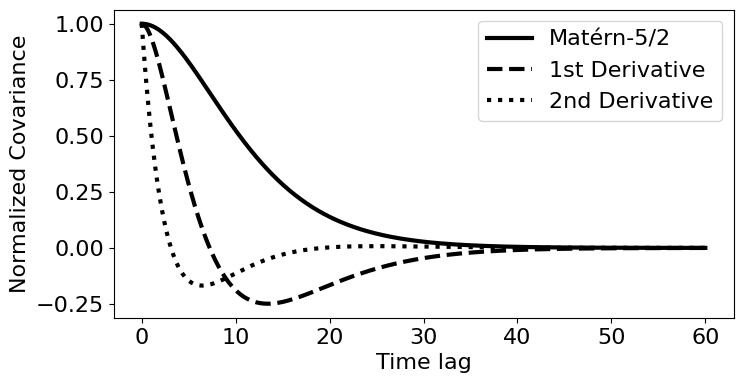

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', family='sans serif', size=16)

dts = jnp.linspace(0, 60, 500)
zeros = jnp.zeros_like(dts)

cov  = kernel(zeros, dts)[0,:]
covd = derivative_kernel(zeros, dts)[0,:]
covdd = derivative2_kernel(zeros, dts)[0,:]

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(dts, cov/cov.max(),     label=r'Matérn-5/2', lw=3, color='k')
ax.plot(dts, covd/covd.max(),   label=r'1st Derivative', lw=3, color='k', ls='--')
ax.plot(dts, covdd/covdd.max(), label=r'2nd Derivative', lw=3, color='k', ls=':')
ax.set(ylabel='Normalized Covariance', xlabel='Time lag');
ax.legend();